### Libraries Import

In [1]:
import os
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Augmentation using GAN (handle data imbalance)

In [2]:
class SingleClassDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith(('.png','jpg','jpeg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.init_size = 14
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 256 * self.init_size * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,  64, 3, padding=1), nn.BatchNorm2d(64),  nn.LeakyReLU(0.2, True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64,   32, 3, padding=1), nn.BatchNorm2d(32),  nn.LeakyReLU(0.2, True),
            nn.Conv2d(32,    3, 3, padding=1), nn.Sigmoid()  # [0,1] output
        )

    def forward(self, z):
        out = self.l1(z).view(z.size(0), 256, self.init_size, self.init_size)
        return self.conv_blocks(out)

class Discriminator(nn.Module):
    def __init__(self, img_size=224):
        super().__init__()
        def cb(in_c, out_c):
            return [
                nn.Conv2d(in_c, out_c, 3, stride=2, padding=1),
                nn.LeakyReLU(0.2, True),
                nn.Dropout(0.4)
            ]
        self.model = nn.Sequential(
            *cb(3,  64),   # 224→112
            *cb(64, 128),  # 112→56
            *cb(128,256),  # 56→28
            nn.Flatten(),
            nn.Linear(256*(img_size//8)*(img_size//8), 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

def train_dcgan(gen, disc, loader, latent_dim, device,
                epochs=200, lr=2e-4, beta1=0.5):
    criterion = nn.BCELoss()
    opt_d = optim.Adam(disc.parameters(), lr=lr, betas=(beta1,0.999))
    opt_g = optim.Adam(gen.parameters(),  lr=lr, betas=(beta1,0.999))
    gen.to(device); disc.to(device)

    for epoch in range(1, epochs+1):
        d_loss_acc, g_loss_acc = 0, 0
        for real in loader:  # num_workers=0 to avoid Windows crashes
            bs = real.size(0)
            real = real.to(device)
            # smoothed real labels=0.9, fake=0
            real_lbl = torch.full((bs,1), 0.9, device=device)
            fake_lbl = torch.zeros((bs,1), device=device)

            # Discriminator step
            disc.zero_grad()
            out_real = disc(real)
            d_real = criterion(out_real, real_lbl)
            z = torch.randn(bs, latent_dim, device=device)
            fake = gen(z)
            out_fake = disc(fake.detach())
            d_fake = criterion(out_fake, fake_lbl)
            (d_real + d_fake).backward()
            opt_d.step()

            # Generator step
            gen.zero_grad()
            valid_lbl = torch.ones((bs,1), device=device)
            out = disc(fake)
            g_loss = criterion(out, valid_lbl)
            g_loss.backward()
            opt_g.step()

            d_loss_acc += (d_real + d_fake).item()
            g_loss_acc += g_loss.item()

        print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss_acc/len(loader):.4f} | G_loss: {g_loss_acc/len(loader):.4f}")

    return gen


data_root      = "dataset/train"
synthetic_root = "synthetic"
os.makedirs(synthetic_root, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = [d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root,d))]
orig_counts = {}
for cls in classes:
    folder = os.path.join(data_root, cls)
    imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.png','jpg','jpeg'))]
    orig_counts[cls] = len(imgs)
max_count = max(orig_counts.values())
print("Original counts:", orig_counts)

gan_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
latent_dim = 100
epochs     = 50
batch_size = 64

synthetic_counts = {}
for cls, cnt in orig_counts.items():
    need = max_count - cnt
    synthetic_counts[cls] = 0
    if need <= 0:
        print(f"[{cls}] has {cnt}, no synthetic needed.")
        continue

    print(f"[{cls}] needs {need} synthetic images → training GAN…")
    # prepare data loader
    ds     = SingleClassDataset(os.path.join(data_root,cls), transform=gan_transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)

    # build & train
    gen  = Generator(latent_dim).to(device)
    disc = Discriminator().to(device)
    gen  = train_dcgan(gen, disc, loader, latent_dim, device,
                        epochs=epochs)

    # generate & save
    out_dir = os.path.join(synthetic_root, cls)
    os.makedirs(out_dir, exist_ok=True)
    for i in tqdm(range(need), desc=f"Generating [{cls}]"):
        z = torch.randn(1, latent_dim, device=device)
        with torch.no_grad():
            fake = gen(z).cpu().squeeze(0)
        pil = transforms.ToPILImage()(fake)
        pil.save(os.path.join(out_dir, f"synthetic_{i}.png"))
        synthetic_counts[cls] += 1

# 4c) Report final counts
total_counts = {cls: orig_counts[cls] + synthetic_counts.get(cls,0) for cls in classes}
print("Synthetic counts:", synthetic_counts)
print("Total counts after augmentation:", total_counts)

Original counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
[NORMAL] needs 2534 synthetic images → training GAN…
Epoch 1/50 | D_loss: 1.1660 | G_loss: 1.4158
Epoch 2/50 | D_loss: 1.3359 | G_loss: 0.9206
Epoch 3/50 | D_loss: 1.3514 | G_loss: 0.8769
Epoch 4/50 | D_loss: 1.3565 | G_loss: 0.8641
Epoch 5/50 | D_loss: 1.3677 | G_loss: 0.8450
Epoch 6/50 | D_loss: 1.3676 | G_loss: 0.8497
Epoch 7/50 | D_loss: 1.3542 | G_loss: 0.8556
Epoch 8/50 | D_loss: 1.3526 | G_loss: 0.8712
Epoch 9/50 | D_loss: 1.3596 | G_loss: 0.8779
Epoch 10/50 | D_loss: 1.3424 | G_loss: 0.8960
Epoch 11/50 | D_loss: 1.3435 | G_loss: 0.8773
Epoch 12/50 | D_loss: 1.3519 | G_loss: 0.8814
Epoch 13/50 | D_loss: 1.3880 | G_loss: 0.8431
Epoch 14/50 | D_loss: 1.3596 | G_loss: 0.8434
Epoch 15/50 | D_loss: 1.3611 | G_loss: 0.8387
Epoch 16/50 | D_loss: 1.3588 | G_loss: 0.8474
Epoch 17/50 | D_loss: 1.3612 | G_loss: 0.8477
Epoch 18/50 | D_loss: 1.3538 | G_loss: 0.8383
Epoch 19/50 | D_loss: 1.3565 | G_loss: 0.8542
Epoch 20/50 | D_loss: 1.3518 

Generating [NORMAL]: 100%|██████████| 2534/2534 [01:15<00:00, 33.70it/s]

[PNEUMONIA] has 3875, no synthetic needed.
Synthetic counts: {'NORMAL': 2534, 'PNEUMONIA': 0}
Total counts after augmentation: {'NORMAL': 3875, 'PNEUMONIA': 3875}


In [2]:
# Hyperparameters
batch_size = 64
num_epochs = 30
lr = 1e-3
num_classes = 2

# Data Transforms
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset loading
real_train_ds = datasets.ImageFolder("dataset/train", transform=basic_transform)
synthetic_ds = datasets.ImageFolder("synthetic", transform=basic_transform)
synthetic_ds.classes = real_train_ds.classes
synthetic_ds.class_to_idx = real_train_ds.class_to_idx

train_ds = ConcatDataset([real_train_ds, synthetic_ds])
val_ds = datasets.ImageFolder("dataset/val", transform=basic_transform)
test_ds = datasets.ImageFolder("dataset/test", transform=basic_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

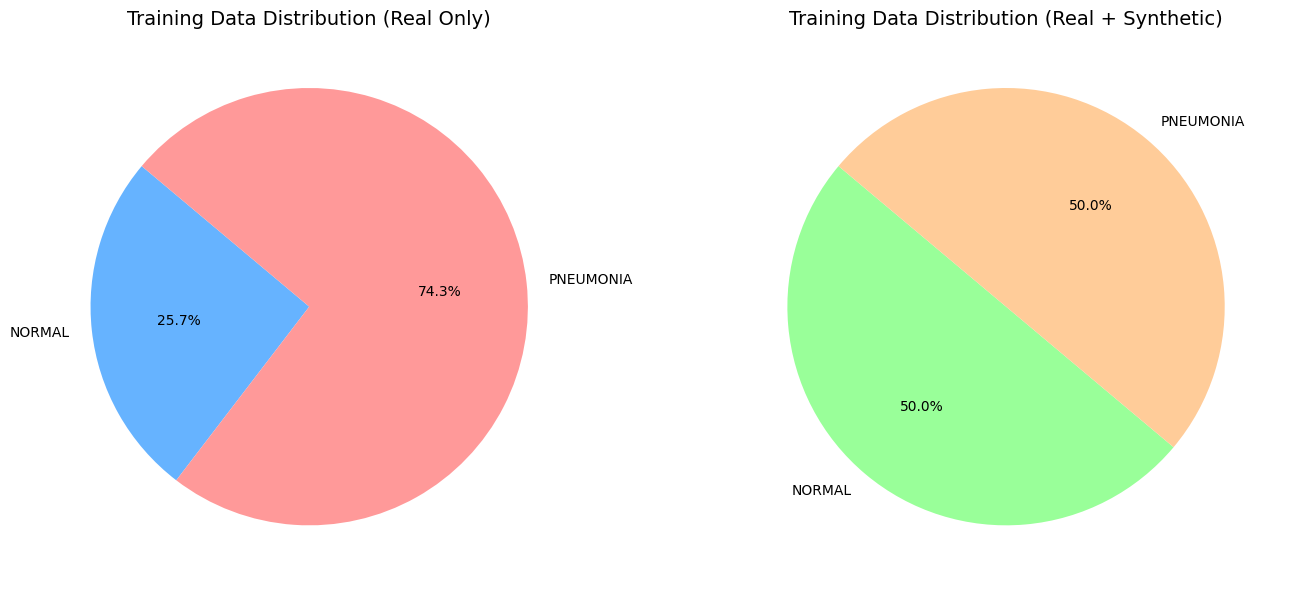

In [3]:
# Count real training data
real_counts = Counter([real_train_ds.targets[i] for i in range(len(real_train_ds))])
real_labels = [real_train_ds.classes[i] for i in real_counts.keys()]
real_sizes = list(real_counts.values())

# Count combined (real + synthetic) data
combined_targets = [real_train_ds.targets[i] for i in range(len(real_train_ds))] + \
                   [synthetic_ds.targets[i] for i in range(len(synthetic_ds))]
combined_counts = Counter(combined_targets)
combined_labels = [real_train_ds.classes[i] for i in combined_counts.keys()]
combined_sizes = list(combined_counts.values())

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real data pie
axes[0].pie(real_sizes, labels=real_labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
axes[0].set_title('Training Data Distribution (Real Only)', fontsize=14)

# Combined data pie
axes[1].pie(combined_sizes, labels=combined_labels, autopct='%1.1f%%', startangle=140, colors=['#99ff99','#ffcc99'])
axes[1].set_title('Training Data Distribution (Real + Synthetic)', fontsize=14)

plt.tight_layout()
plt.show()

### VGG and Neural Network

In [ ]:
# Custom Model
class VGG16Enhanced(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Enhanced, self).__init__()
        base_model = models.vgg16(pretrained=True)
        for param in base_model.features.parameters():
            param.requires_grad = False
        
        self.features = base_model.features
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

In [ ]:
# Model, Loss, Optimizer, Scheduler
model = VGG16Enhanced(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6)

# Training and Validation Loop
train_acc_hist, val_acc_hist = [], []
train_loss_hist, val_loss_hist = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

# Test Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())


c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[Epoch 1/30] Training: 100%|██████████| 122/122 [01:26<00:00,  1.41it/s]


Epoch 1/30 -> Train Loss: 0.2042, Val Loss: 0.2453 | Train Acc: 0.9185, Val Acc: 0.8750


[Epoch 2/30] Training: 100%|██████████| 122/122 [01:28<00:00,  1.38it/s]


Epoch 2/30 -> Train Loss: 0.0758, Val Loss: 0.2852 | Train Acc: 0.9705, Val Acc: 0.8750


[Epoch 3/30] Training: 100%|██████████| 122/122 [01:29<00:00,  1.36it/s]


Epoch 3/30 -> Train Loss: 0.0636, Val Loss: 0.7711 | Train Acc: 0.9763, Val Acc: 0.6250


[Epoch 4/30] Training: 100%|██████████| 122/122 [01:31<00:00,  1.34it/s]


Epoch 4/30 -> Train Loss: 0.0599, Val Loss: 0.4319 | Train Acc: 0.9783, Val Acc: 0.6875


[Epoch 5/30] Training: 100%|██████████| 122/122 [01:31<00:00,  1.33it/s]


Epoch 5/30 -> Train Loss: 0.0556, Val Loss: 0.0456 | Train Acc: 0.9786, Val Acc: 1.0000


[Epoch 6/30] Training: 100%|██████████| 122/122 [01:32<00:00,  1.31it/s]


Epoch 6/30 -> Train Loss: 0.0468, Val Loss: 0.0917 | Train Acc: 0.9813, Val Acc: 1.0000


[Epoch 7/30] Training: 100%|██████████| 122/122 [01:32<00:00,  1.32it/s]


Epoch 7/30 -> Train Loss: 0.0513, Val Loss: 0.0360 | Train Acc: 0.9809, Val Acc: 1.0000


[Epoch 8/30] Training: 100%|██████████| 122/122 [01:32<00:00,  1.32it/s]


Epoch 8/30 -> Train Loss: 0.0459, Val Loss: 0.1232 | Train Acc: 0.9837, Val Acc: 0.9375


[Epoch 9/30] Training: 100%|██████████| 122/122 [01:32<00:00,  1.31it/s]


Epoch 9/30 -> Train Loss: 0.0543, Val Loss: 0.0437 | Train Acc: 0.9783, Val Acc: 1.0000


[Epoch 10/30] Training: 100%|██████████| 122/122 [02:18<00:00,  1.14s/it]


Epoch 10/30 -> Train Loss: 0.0417, Val Loss: 0.0151 | Train Acc: 0.9850, Val Acc: 1.0000


[Epoch 11/30] Training: 100%|██████████| 122/122 [01:46<00:00,  1.14it/s]


Epoch 11/30 -> Train Loss: 0.0370, Val Loss: 0.1188 | Train Acc: 0.9857, Val Acc: 0.9375


[Epoch 12/30] Training: 100%|██████████| 122/122 [01:50<00:00,  1.10it/s]


Epoch 12/30 -> Train Loss: 0.0383, Val Loss: 0.1883 | Train Acc: 0.9857, Val Acc: 0.8750


[Epoch 13/30] Training: 100%|██████████| 122/122 [01:33<00:00,  1.30it/s]


Epoch 13/30 -> Train Loss: 0.0340, Val Loss: 0.0479 | Train Acc: 0.9876, Val Acc: 1.0000


[Epoch 14/30] Training: 100%|██████████| 122/122 [01:34<00:00,  1.29it/s]


Epoch 14/30 -> Train Loss: 0.0334, Val Loss: 0.0950 | Train Acc: 0.9889, Val Acc: 0.9375


[Epoch 15/30] Training: 100%|██████████| 122/122 [01:34<00:00,  1.29it/s]


Epoch 15/30 -> Train Loss: 0.0280, Val Loss: 0.1233 | Train Acc: 0.9897, Val Acc: 0.9375


[Epoch 16/30] Training: 100%|██████████| 122/122 [01:32<00:00,  1.31it/s]


Epoch 16/30 -> Train Loss: 0.0243, Val Loss: 0.1622 | Train Acc: 0.9912, Val Acc: 0.9375


[Epoch 17/30] Training: 100%|██████████| 122/122 [01:34<00:00,  1.29it/s]


Epoch 17/30 -> Train Loss: 0.0274, Val Loss: 0.0515 | Train Acc: 0.9901, Val Acc: 1.0000


[Epoch 18/30] Training: 100%|██████████| 122/122 [01:33<00:00,  1.30it/s]


Epoch 18/30 -> Train Loss: 0.0206, Val Loss: 0.1213 | Train Acc: 0.9910, Val Acc: 0.9375


[Epoch 19/30] Training: 100%|██████████| 122/122 [01:34<00:00,  1.30it/s]


Epoch 19/30 -> Train Loss: 0.0193, Val Loss: 0.0916 | Train Acc: 0.9934, Val Acc: 0.9375


[Epoch 20/30] Training: 100%|██████████| 122/122 [01:35<00:00,  1.28it/s]


Epoch 20/30 -> Train Loss: 0.0167, Val Loss: 0.0948 | Train Acc: 0.9951, Val Acc: 0.9375


[Epoch 21/30] Training: 100%|██████████| 122/122 [01:34<00:00,  1.29it/s]


Epoch 21/30 -> Train Loss: 0.0170, Val Loss: 0.1207 | Train Acc: 0.9933, Val Acc: 0.9375


[Epoch 22/30] Training: 100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epoch 22/30 -> Train Loss: 0.0164, Val Loss: 0.1064 | Train Acc: 0.9939, Val Acc: 0.9375


[Epoch 23/30] Training: 100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 23/30 -> Train Loss: 0.0160, Val Loss: 0.0749 | Train Acc: 0.9946, Val Acc: 0.9375


[Epoch 24/30] Training: 100%|██████████| 122/122 [01:36<00:00,  1.26it/s]


Epoch 24/30 -> Train Loss: 0.0120, Val Loss: 0.1178 | Train Acc: 0.9955, Val Acc: 0.9375


[Epoch 25/30] Training: 100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 25/30 -> Train Loss: 0.0118, Val Loss: 0.1438 | Train Acc: 0.9950, Val Acc: 0.9375


[Epoch 26/30] Training: 100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 26/30 -> Train Loss: 0.0129, Val Loss: 0.1242 | Train Acc: 0.9960, Val Acc: 0.9375


[Epoch 27/30] Training: 100%|██████████| 122/122 [01:38<00:00,  1.24it/s]


Epoch 27/30 -> Train Loss: 0.0121, Val Loss: 0.1290 | Train Acc: 0.9950, Val Acc: 0.9375


[Epoch 28/30] Training: 100%|██████████| 122/122 [01:43<00:00,  1.18it/s]


Epoch 28/30 -> Train Loss: 0.0104, Val Loss: 0.1412 | Train Acc: 0.9966, Val Acc: 0.9375


[Epoch 29/30] Training: 100%|██████████| 122/122 [01:46<00:00,  1.15it/s]


Epoch 29/30 -> Train Loss: 0.0091, Val Loss: 0.1279 | Train Acc: 0.9966, Val Acc: 0.9375


[Epoch 30/30] Training: 100%|██████████| 122/122 [01:40<00:00,  1.21it/s]


Epoch 30/30 -> Train Loss: 0.0095, Val Loss: 0.1558 | Train Acc: 0.9961, Val Acc: 0.9375


### Evaluation

In [3]:
# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=real_train_ds.classes))
print(f"Test Accuracy:  {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1 Score:       {f1:.4f}")


--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.94      0.74      0.82       234
   PNEUMONIA       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624

Test Accuracy:  0.8830
Precision:      0.8997
Recall:         0.8534
F1 Score:       0.8685


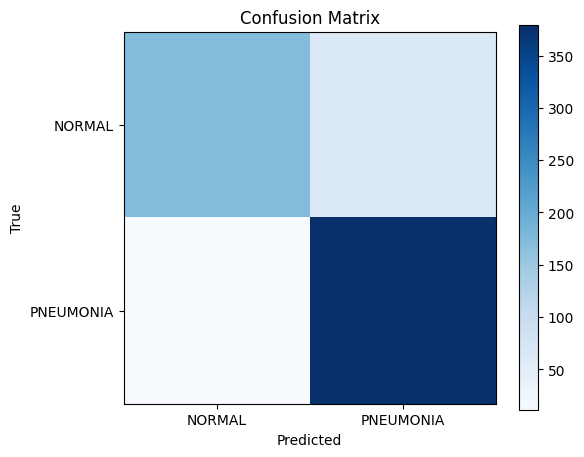

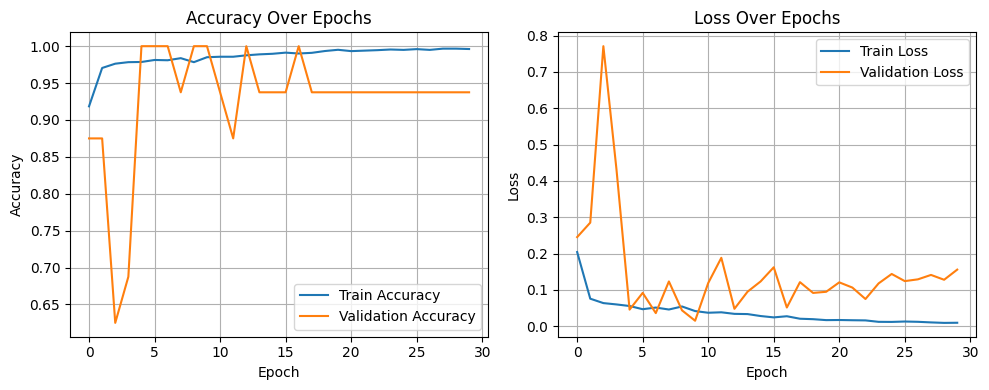

In [4]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(num_classes), real_train_ds.classes)
plt.yticks(np.arange(num_classes), real_train_ds.classes)
plt.colorbar()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Prediction

In [3]:
import torch
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import os

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Same transforms as training ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Class mapping (update this as per your actual class names) ---
class_names = ['Normal', 'Pneumonia']  # example

# --- Define the model architecture ---
class VGG16Enhanced(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Enhanced, self).__init__()
        base_model = models.vgg16(pretrained=True)
        for param in base_model.features.parameters():
            param.requires_grad = False
        
        self.features = base_model.features
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

# --- Load model ---
model = VGG16Enhanced(num_classes=2)  # Update if you have more classes
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()

# --- Prediction Function ---
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        class_index = predicted.item()
        class_name = class_names[class_index]
    
    print(f"Predicted class: {class_name}")
    return class_name

# test_image_path = "dataset/train/PNEUMONIA/person1_bacteria_2.jpeg"
test_image_path = "dataset/train/NORMAL/NORMAL2-IM-1385-0001.jpeg"

predict_image(test_image_path)

Predicted class: Normal


'Normal'